# Multiple Grid Cells in MUSICA
In MUSICA, the <i>State</i> object that is present within the <i>Solver</i> object has an attribute called <i>number_of_grid_cells</i>.</br>
This attribute dictates the number of independent sets of well-mixed air masses whose chemical system will be solved by the same numerical solver.</br>
This tutorial will go over a simple example of solving a multi-grid-cell chemical system in MUSICA.

## MUSICA: Before Getting Started

It is heavily recommended to go through the tutorials in the MusicBox repository first before going through the MUSICA ones since the former explains the workflow used in the latter.</br>
However, if you are only interested in MUSICA, here's how you can set up a virtual environment for it:

```
conda create --name musica python=3.9
conda activate musica
pip install musica
conda install ipykernel scikit-learn seaborn scipy dask
```

## 1. Importing Libraries
Below is a list of the required libraries for this tutorial:

In [1]:
import musica
import musica.mechanism_configuration as mc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
pd.set_option('display.float_format', str) # This is done to make the arrays more readable
np.set_printoptions(suppress=True) # This is done to make the arrays more readable

## 2. Defining a System

This code snippet is a MUSICA version of setting up a system, which has an identical workflow to MusicBox.</br>
For an explanation of this code in MusicBox, please refer to the Basic Workflow tutorial in the MusicBox repository.

In [2]:
A = mc.Species(name="A") # Create each of the species with their respective names
B = mc.Species(name="B")
C = mc.Species(name="C")
species = [A, B, C] # Bundle the species into a list
gas = mc.Phase(name="gas", species=species) # Create a gas phase object containing the species

r1 = mc.Arrhenius( # Create the reactions with their name, constants, reactants, products, and phase
    name="A_to_B",
    A=4.0e-3,  # Pre-exponential factor
    C=50,      # Activation energy (units assumed to be K)
    reactants=[A],
    products=[B],
    gas_phase=gas
)

r2 = mc.Arrhenius(
    name="B_to_C",
    A=4.0e-3,
    C=50,  
    reactants=[B],
    products=[C],
    gas_phase=gas
)

mechanism = mc.Mechanism( # Define the mechanism which contains a name, the species, the phases, and reactions
    name="musica_micm_example",
    species=species,
    phases=[gas],
    reactions=[r1, r2]
)

## 3. Creating the Solver
Something more unique to MUSICA is that you have to manually define the solver.</br>
A solver integrates the chemical reactions that determine how atmospheric chemistry proceeds over time.</br>
There are a handful of solvers available, but Rosenbrock Standard Order will be used here.</br>
For more information on the types of solvers available, go [here](https://ncar.github.io/micm/user_guide/solver_configurations.html).

In [3]:
solver = musica.MICM(mechanism = mechanism, solver_type = musica.SolverType.rosenbrock_standard_order)

## 4. Creating the State
For MUSICA, the state must be created manually as well, with the number of grid cells being passed into the <i>create_state()</i> function.</br>
The state represents everything pertinent to solve chemistry. By solving, we meaning determining the concentrations at the next time step.</br>
Feel free to change the <i>num_grid_cells</i> value to experiment yourself.

In [4]:
num_grid_cells = 2
state = solver.create_state(num_grid_cells)

## 5. Populating the Grid Cells
5 dimensions will be used to populate the data for each of the air masses:
* temperature (Kelvin),
* pressure (Pascals), and
* the concentrations of each of the species (mol/m<sup>3</sup>).

The NumPy array has the <i>reshape()</i> function called on it so that it can be split up in the next step.</br>
The two arguments specify the number of rows and columns of the array, where -1 means any number of rows.</br>
Do note that the ordering inside the array matters and cannot be changed.

In [5]:
box_model_values = np.array([[300, 101253.3, 5, 5, 5], [100, 11253.3, 20, 3, 7]])
box_model_values = box_model_values.reshape(-1, 5)
display(box_model_values)

array([[   300. , 101253.3,      5. ,      5. ,      5. ],
       [   100. ,  11253.3,     20. ,      3. ,      7. ]])

## 6. Splitting up the Array Output
Next, the values from the <i>box_model_values</i> array are taken and populated into variables so that they can be passed into the solver's state.</br>
The sample is organized into 5 columns that represent the 5 variables.</br>
The sample's rows each represent a distinct grid cell.</br>
These columns are populated into their respective variables and then passed into the solver's state.</br>
Do note that <i>set_conditions()</i> and <i>set_concentrations()</i> must be called with their respective arguments for the solver to successfully run.</br>
The concentrations must go through the extra step of being bundled into a dictionary since MUSICA explicitly requires a dictionary argument in the <i>set_concentrations</i> function.</br>
Lastly, an empty array is initialized to represent the solved concentration array at every time step, as well as the time step length, simulation length, and the current time step (all in seconds).

In [6]:
temperatures = box_model_values[:, 0]
pressures = box_model_values[:, 1]
concentrations = {
    "A": [],
    "B": [],
    "C": []
}
concentrations["A"] = box_model_values[:, 2]
concentrations["B"] = box_model_values[:, 3]
concentrations["C"] = box_model_values[:, 4]

state.set_conditions(temperatures, pressures)
state.set_concentrations(concentrations)
concentrations_solved = []
time_step_length = 1
sim_length = 60
curr_time = 0

## 7. Running the Solver
This code solves the system at every specified time step and the solved concentrations are appended to the array.</br>
The first step will always be the initial conditions since at time = 0 seconds the reaction has not begun.

In [7]:
while curr_time <= sim_length:
    solver.solve(state, curr_time)
    concentrations_solved.append(state.get_concentrations())
    curr_time += time_step_length

## 8. Preparing the Results (Advanced; Optional Read)
Here, a new array is made that grabs only the first value (grid cell) for each key (species) at every time step.</br>
The time step index is divided by the time_step_length to account for time step lengths that are greater than one for proper array indexing.</br>
That new array is then passed into a Pandas DataFrame with the concentration columns renamed.</br>
Next, a time column is created from a range that represents the elapsed time at each time step.</br>
In this simulation, the temperature, pressure, and air density are all constant, so numpy's <i>repeat()</i> function is used to repeat their respective values for every time step.</br>
Once all the attributes are added to the DataFrame, their order is changed to follow a more logical flow.</br>
Due to the complexity of this code cell, it has been bundled into a function that takes in an argument for the grid cell you wish to convert to a DataFrame.</br>
The function is then called twice, one for each grid cell index.

In [8]:
def convert_results_single_cell(cell_index):
    concentrations_solved_pd = []
    for i in range(0, sim_length + 1, time_step_length):
        concentrations_solved_pd.append({species: concentration[cell_index] for species, concentration in concentrations_solved[int(i/time_step_length)].items()})
    df = pd.DataFrame(concentrations_solved_pd)
    df = df.rename(columns = {'A' : 'CONC.A.mol m-3', 'B' : 'CONC.B.mol m-3', 'C' : 'CONC.C.mol m-3'})
    df['time.s'] = list(map(float, range(0, sim_length + 1, time_step_length)))
    df['ENV.temperature.K'] = np.repeat(temperatures[cell_index], sim_length/time_step_length + 1.0)
    df['ENV.pressure.Pa'] = np.repeat(pressures[cell_index], sim_length/time_step_length + 1.0)
    df['ENV.air number density.mol m-3'] = np.repeat(state.get_conditions()['air_density'][cell_index], sim_length/time_step_length + 1.0)
    df = df[['time.s', 'ENV.temperature.K', 'ENV.pressure.Pa', 'ENV.air number density.mol m-3', 'CONC.A.mol m-3', 'CONC.B.mol m-3', 'CONC.C.mol m-3']]
    return concentrations_solved_pd, df

In [9]:
concentrations_solved_pd_0, df_0 = convert_results_single_cell(0)
concentrations_solved_pd_1, df_1 = convert_results_single_cell(1)

## 9. Viewing the Results
With the DataFrames being fully prepared now, they are displayed and plotted to show the evolution of both of the systems over time.

,time.s,ENV.temperature.K,ENV.pressure.Pa,ENV.air number density.mol m-3,CONC.A.mol m-3,CONC.B.mol m-3,CONC.C.mol m-3
0,0.0,300.0,101253.3,40.59324282282551,5.0,5.0,5.0
1,1.0,300.0,101253.3,40.59324282282551,4.976428528398802,4.999944351093875,5.0236271205073235
2,2.0,300.0,101253.3,40.59324282282551,4.929618429433882,4.999502304184354,5.070879266381759
3,3.0,300.0,101253.3,40.59324282282551,4.860227571898497,4.998027906909858,5.141744521191641
4,4.0,300.0,101253.3,40.59324282282551,4.769223461910271,4.994590343685047,5.236186194404681
...,...,...,...,...,...,...,...
56,56.0,300.0,101253.3,40.59324282282551,0.002651107160467822,0.022649502677897896,14.974699390161621
57,57.0,300.0,101253.3,40.59324282282551,0.0020250213465128905,0.01784640325737679,14.980128575396096
58,58.0,300.0,101253.3,40.59324282282551,0.0015394935543717359,0.01398971727457048,14.984470789171041
59,59.0,300.0,101253.3,40.59324282282551,0.0011648552812954611,0.010910311593626484,14.987924833125062


,time.s,ENV.temperature.K,ENV.pressure.Pa,ENV.air number density.mol m-3,CONC.A.mol m-3,CONC.B.mol m-3,CONC.C.mol m-3
0,0.0,100.0,11253.3,13.53460893002309,20.0,3.0,7.0
1,1.0,100.0,11253.3,13.53460893002309,19.868536268722355,3.1113111545426153,7.020152576735027
2,2.0,100.0,11253.3,13.53460893002309,19.608195525999147,3.329170747441501,7.062633726559351
3,3.0,100.0,11253.3,13.53460893002309,19.22406658832665,3.6442931108015326,7.131640300871819
4,4.0,100.0,11253.3,13.53460893002309,18.723574920030497,4.043334633782276,7.233090446187235
...,...,...,...,...,...,...,...
56,56.0,100.0,11253.3,13.53460893002309,0.0005360881626445901,0.005726115410867138,29.993737796426494
57,57.0,100.0,11253.3,13.53460893002309,0.00036805009976445557,0.0040698479741160445,29.995562101926122
58,58.0,100.0,11253.3,13.53460893002309,0.00025101920969299854,0.002871932602189201,29.996877048188125
59,59.0,100.0,11253.3,13.53460893002309,0.00017007318795390593,0.0020121301960677983,29.997817796615987


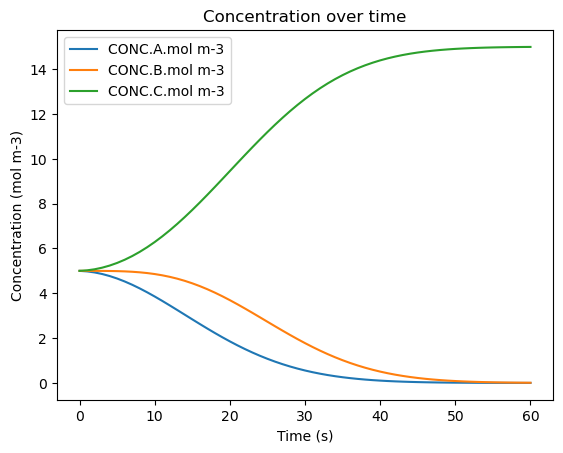

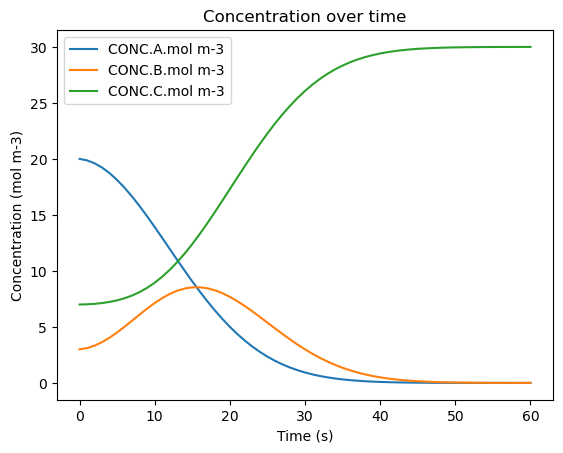

In [10]:
display(df_0)
display(df_1)
df_0.plot(x='time.s', y=['CONC.A.mol m-3', 'CONC.B.mol m-3', 'CONC.C.mol m-3'], title='Concentration over time', ylabel='Concentration (mol m-3)', xlabel='Time (s)')
df_1.plot(x='time.s', y=['CONC.A.mol m-3', 'CONC.B.mol m-3', 'CONC.C.mol m-3'], title='Concentration over time', ylabel='Concentration (mol m-3)', xlabel='Time (s)')
plt.show()